### EMAT : Robust Optimization

Robust optimization is a branch of optimization methodology for solving an optimization problem where data is uncertain and solutions are found based on a set of certain measures of robustness using an iterative process. In robust optimization, optimal decisions are made for different realizations of uncertainties where the solution space can be constrained based on certain policy parameters or performance measures. 

In this notebook, we demonstrate how to use robust optimization for finding optimal solutions in EMAT. First, we import the set of python packages that we need for running robust optimization. We need a scope file for model object where uncertainties, policy levers and performance measures for core/meta-models are defined using a recommended format. We use `emat.Scope()` to create a `Scope` object. Then, we create a database and store the `Scope` object using `.store_scope(emat.SQLiteDB())`.

##### Import packages and set logger

In [1]:
import ema_workbench
import os, numpy, pandas, functools
import emat
from emat.util.xmle import Show
import matplotlib.pyplot as plt
logger = emat.util.loggers.log_to_stderr(20, True)

##### Create a scope and store in database

In [2]:
road_scope = emat.Scope(emat.package_file('model','tests','road_test.yaml'))
print(road_scope)

emat_db = emat.SQLiteDB()
road_scope.store_scope(emat_db)
emat_db.read_scope_names()

[00:13.64] MainProcess/INFO: running script scope.sql
[00:13.64] MainProcess/INFO: running script exp_design.sql
[00:13.64] MainProcess/INFO: running script meta_model.sql


<emat.Scope with 2 constants, 7 uncertainties, 4 levers, 7 measures>


['EMAT Road Test']

#### Import core model

When we have the scope stored in our database, we import the core model to define a model object using `PythonCoreModel()` class. In this example, the core model is constructed as a class and referred to as `Road_Capacity_Investment`. We also need to import an evaluator for running the optimization process. For this demonstration, `SequentialEvaluator` is used to simplify the process.

In [3]:
from emat.model.core_python import PythonCoreModel
from emat.model.core_python import Road_Capacity_Investment
from ema_workbench import SequentialEvaluator

In [4]:
# Define model object and evaluator

m = PythonCoreModel(Road_Capacity_Investment, scope = road_scope, db = emat_db)
eval_seq = SequentialEvaluator(m)

#### Define robustness functions

For robust optimization, we need a set of robustness functions that essentially defines a collection of robustness metrics. Each robustness function can be defined as an outcome measure of  the core model using a class in `emat` called `Measure()`. The first argument in `Measure()` is a `str` type name for the robustness measure. We can also set our preferred direction of measures (`INFO`, `MINIMIZE` and `MAXIMIZE`) using `kind` argument. The name of raw measure as output by the core model is specified by `variable_name`. Finally, a callable function can be defined in `function` to transform the raw measure as robustness metric. `min` and `max` arguments specify the minimum and maximum value respectively that should be observed for any realization of uncertainties.

In [5]:
from emat import Measure, Constraint

In [6]:
# Define robustness functions

robustness_functions = [Measure('Expected Build Travel Time', 
                                kind = Measure.INFO, 
                                variable_name = 'build_travel_time', 
                                function = numpy.mean,),
                        Measure('Expected Time Savings', 
                                kind = Measure.INFO, 
                                variable_name = 'time_savings', 
                                function = numpy.mean,),
                        Measure('Expected Net Benefit', 
                                kind = Measure.MINIMIZE, 
                                variable_name = 'net_benefits', 
                                function = numpy.mean, min = 0, max = 1000),
                        Measure('95%ile Capacity Expansion Cost', 
                                kind = Measure.MINIMIZE, 
                                variable_name = 'cost_of_capacity_expansion', 
                                function = functools.partial(numpy.percentile, q = 95), min = 0, max = 800),
                        Measure('99%ile Value of Time Saving', 
                                kind = Measure.MAXIMIZE, 
                                variable_name = 'value_of_time_savings', 
                                function = functools.partial(numpy.percentile, q = 99), min = 0, max = 1000)]



#### Define constraints

The robust optimization process solutions can be constrained to only include solutions that satisfy certain constraints. These constraints can be based on the policy lever parameters that are contained in the core model, the aggregate performance measures identified in the list of robustness functions, or some combination of levers and aggregate measures.  Importantly, the constraints *cannot* be imposed on the exogenous uncertainties, nor directly on the output measures from the core models (or the equivalent meta-model). This is because the robust version of the model aggregates a number of individual core model runs, and effectively hides these two components from the optimization engine.  

One way to work around this limitation, at least on the output measures, is to write robustness functions that transmit the relevant output measures through the aggregation process.  For example, to constrain the robust search only to instances where a particular output measure is always positive, then write a robustness function that takes the *minimum* value of the targeted performance measure, and write a constraint that ensures that the minimum value is always positive.  This approach should be used with caution, however, as it may severely limit the search space.

In this example, we want only the solutions when the output measure `net_benefits` is always positive. To use this constraint, we define a robustness measure `Expected Net Benefit` mentioned above to consider the minimum value of this measure. Then, we define the constraint using `Constraint()` with a name for this constraint, a name of outcome measure (`Expected Net Benefit`) and a function that imposes this control over solutions.


In [7]:
# Define Constraints
constraint_1 = Constraint("Maximum Interest Rate", 
                          parameter_names = "interest_rate", 
                          function = Constraint.must_be_less_than(0.03),)

## Constraint based on outcome
constraint_2 = Constraint("Minimum Net Benefit", 
                          outcome_names = "Expected Net Benefit", 
                          function = Constraint.must_be_greater_than(0),)

#### Specify convergence metrics

For any optimization problem, it is always important to keep track of the convergence process using various convergence metrics. In `emat`, there are two classes - `HyperVolume` and `EpsilonProgress` that are used to track convergence metrics in the optimization process. `ConvergenceMetrics()` class takes both metrics for the robustness measures defined in the list of robustness functions.

In [8]:
from emat.optimization import HyperVolume, EpsilonProgress, SolutionViewer, ConvergenceMetrics

convergence_metrics = ConvergenceMetrics(HyperVolume.from_outcomes(robustness_functions),
                                         EpsilonProgress(),
                                         SolutionViewer.from_model_and_outcomes(m, robustness_functions),)

#### Run robust optimization

As our model object, robustness measures, constraints and convergence metrics are all defined now, we can run the optimization process on the model object using `robust_optimize()` function. We generate `n` number of random scenarios using `scenarios = n` argument and specify the number of function evaluations in `nfe`. Please note that `nfe` must be significantly higher in real applications to observe a good convergence that should return a set of optimal solutions we generally look for. 

`robust_optimize()` returns two dataframes - one with the model parameters and robustness measures, and the other with convergence information.

In [9]:
robust_results, convergence = m.robust_optimize(robustness_functions,
                                                scenarios = 500,
                                                nfe = 50000,
                                                constraints = [constraint_1, constraint_2],
                                                epsilons  =[0.05,]*len(robustness_functions),
                                                convergence = convergence_metrics,
                                                evaluator = eval_seq,)

[00:43.66] MainProcess/INFO: EpsNSGAII starting
[00:43.69] MainProcess/INFO: generation 0: 0/50000 nfe
[01:59.78] MainProcess/INFO: generation 5: 500/50000 nfe
[03:14.27] MainProcess/INFO: generation 10: 1000/50000 nfe
[04:32.17] MainProcess/INFO: generation 15: 1500/50000 nfe
[05:50.82] MainProcess/INFO: generation 20: 2000/50000 nfe
[07:09.29] MainProcess/INFO: generation 25: 2500/50000 nfe
[08:24.62] MainProcess/INFO: generation 30: 3000/50000 nfe
[09:39.76] MainProcess/INFO: generation 35: 3500/50000 nfe
[10:55.41] MainProcess/INFO: generation 40: 4000/50000 nfe
[12:12.60] MainProcess/INFO: generation 45: 4500/50000 nfe
[13:27.14] MainProcess/INFO: generation 50: 5000/50000 nfe
[14:42.80] MainProcess/INFO: generation 55: 5500/50000 nfe
[15:58.39] MainProcess/INFO: generation 60: 6000/50000 nfe
[17:15.37] MainProcess/INFO: generation 65: 6500/50000 nfe
[18:31.98] MainProcess/INFO: generation 70: 7000/50000 nfe
[19:48.91] MainProcess/INFO: generation 75: 7500/50000 nfe
[21:09.03] Mai

In [10]:
robust_results.head()

,expand_capacity,amortization_period,debt_type,interest_rate_lock,Expected Build Travel Time,Expected Time Savings,Expected Net Benefit,95%ile Capacity Expansion Cost,99%ile Value of Time Saving
0,16.348233,46,Paygo,True,70.646410,10.501889,1.611826,61.865480,295.154788
1,9.594457,42,Paygo,True,73.948808,7.199491,4.626741,38.225506,206.210873
2,1.786879,31,Paygo,True,79.509382,1.638917,1.008908,9.007427,48.024064
3,1.541722,32,Paygo,True,79.724713,1.423586,1.080281,7.598566,41.734337
4,5.630059,35,Paygo,True,76.484629,4.663670,2.499903,25.350071,135.280404


Using the second output from `robust_optimize()`, we can plot the progress of convergence metrics with number of function evaluations.

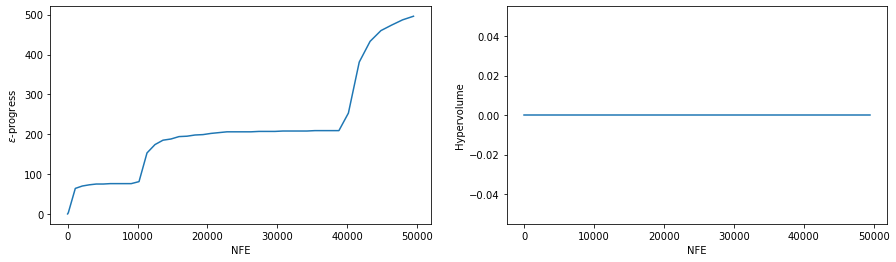

In [11]:
# Plot convergence metrics

fig, (ax1, ax2) = plt.subplots(ncols = 2, sharex = True, figsize=(15,4))

# Plot for Epsilon-progress
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax1.set_xlabel('NFE')


# Plot for Hypervolume
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('Hypervolume')
ax2.set_xlabel('NFE')
plt.show()

`emat` comes with parallel axes plot that helps visualize each solution found in robust optimization. Each line in this plot is a set of points placed on each vertical axis that are connected together to represent a solution. Parallel axis plot is very useful for optimal decision-making as we can compare the parameters side-by-side and understand their relationships with robustness measures.

<xmle.Elem 'img' with 0 children>
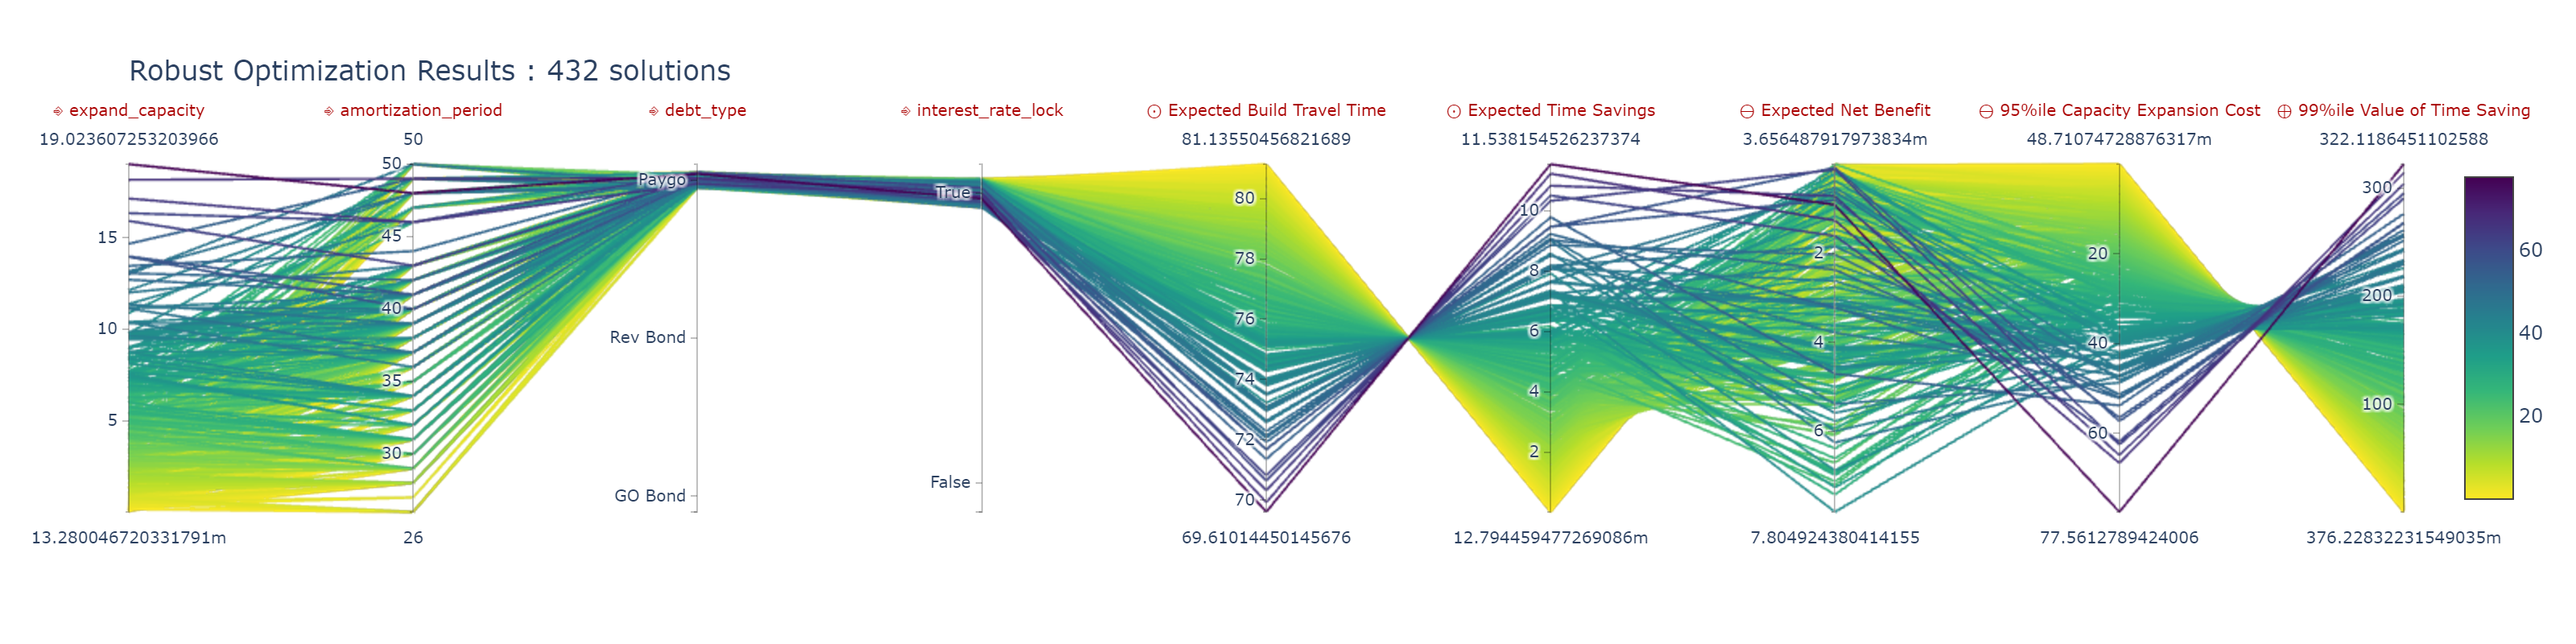

In [12]:
import emat.viz.parcoords

pc = emat.viz.parcoords.parallel_coords(
    m.ensure_dtypes(robust_results),
    model=m,
    robustness_functions=robustness_functions,
    color_dim = '95%ile Capacity Expansion Cost',
    colorscale = 'viridis',
    title = 'Robust Optimization Results : {} solutions'.format(robust_results.shape[0])
)

Show(pc, format = 'png', width = 1600, height = 400, scale = 2)

____